Vehicle Make and Model Recognition Using VMMRdb 

Setting up the environment

Here I am using a remote server with gpu acess. First I created a github repo. Then cloned that repo to my server location.Initialized the server with required libraries. Created a seperate cuda environment. 

setting up required libraries 

In [3]:
import os
import torch
import timm
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

/home/kalinga/miniconda3/envs/venu_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#check the GPU support 
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("selecetd device", device)

selecetd device cuda


1. Dataset Exploration and preparation
 
our dataset is VMMRdb with 291 car makes models and 9000+ classes


Citation: A Large and Diverse Dataset for Improved Vehicle Make and Model Recognition
F. Tafazzoli, K. Nishiyama and H. Frigui
In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops 2017. 

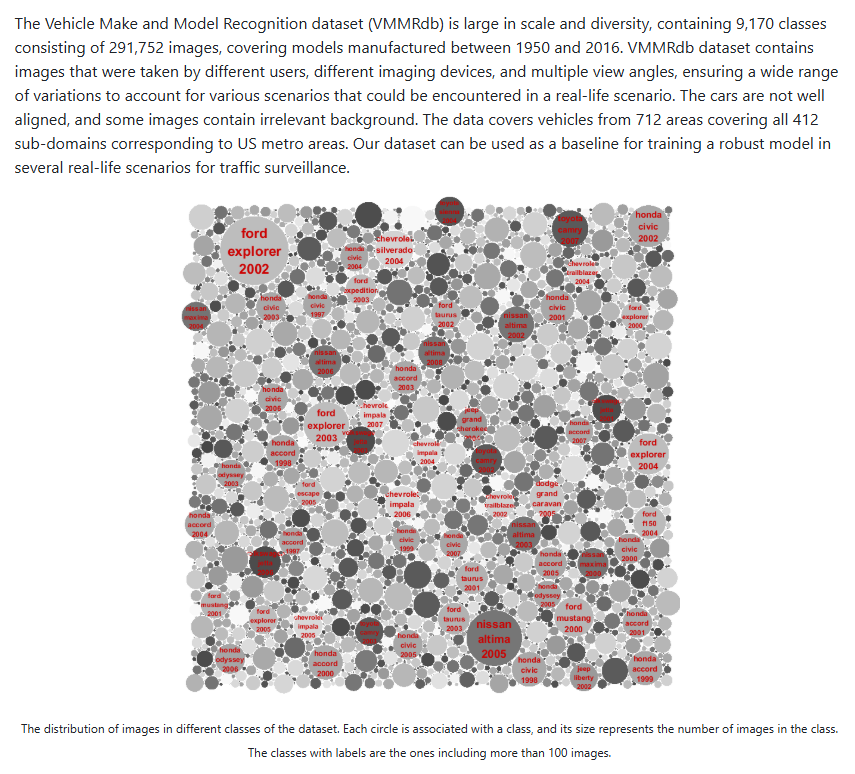

My data folder 
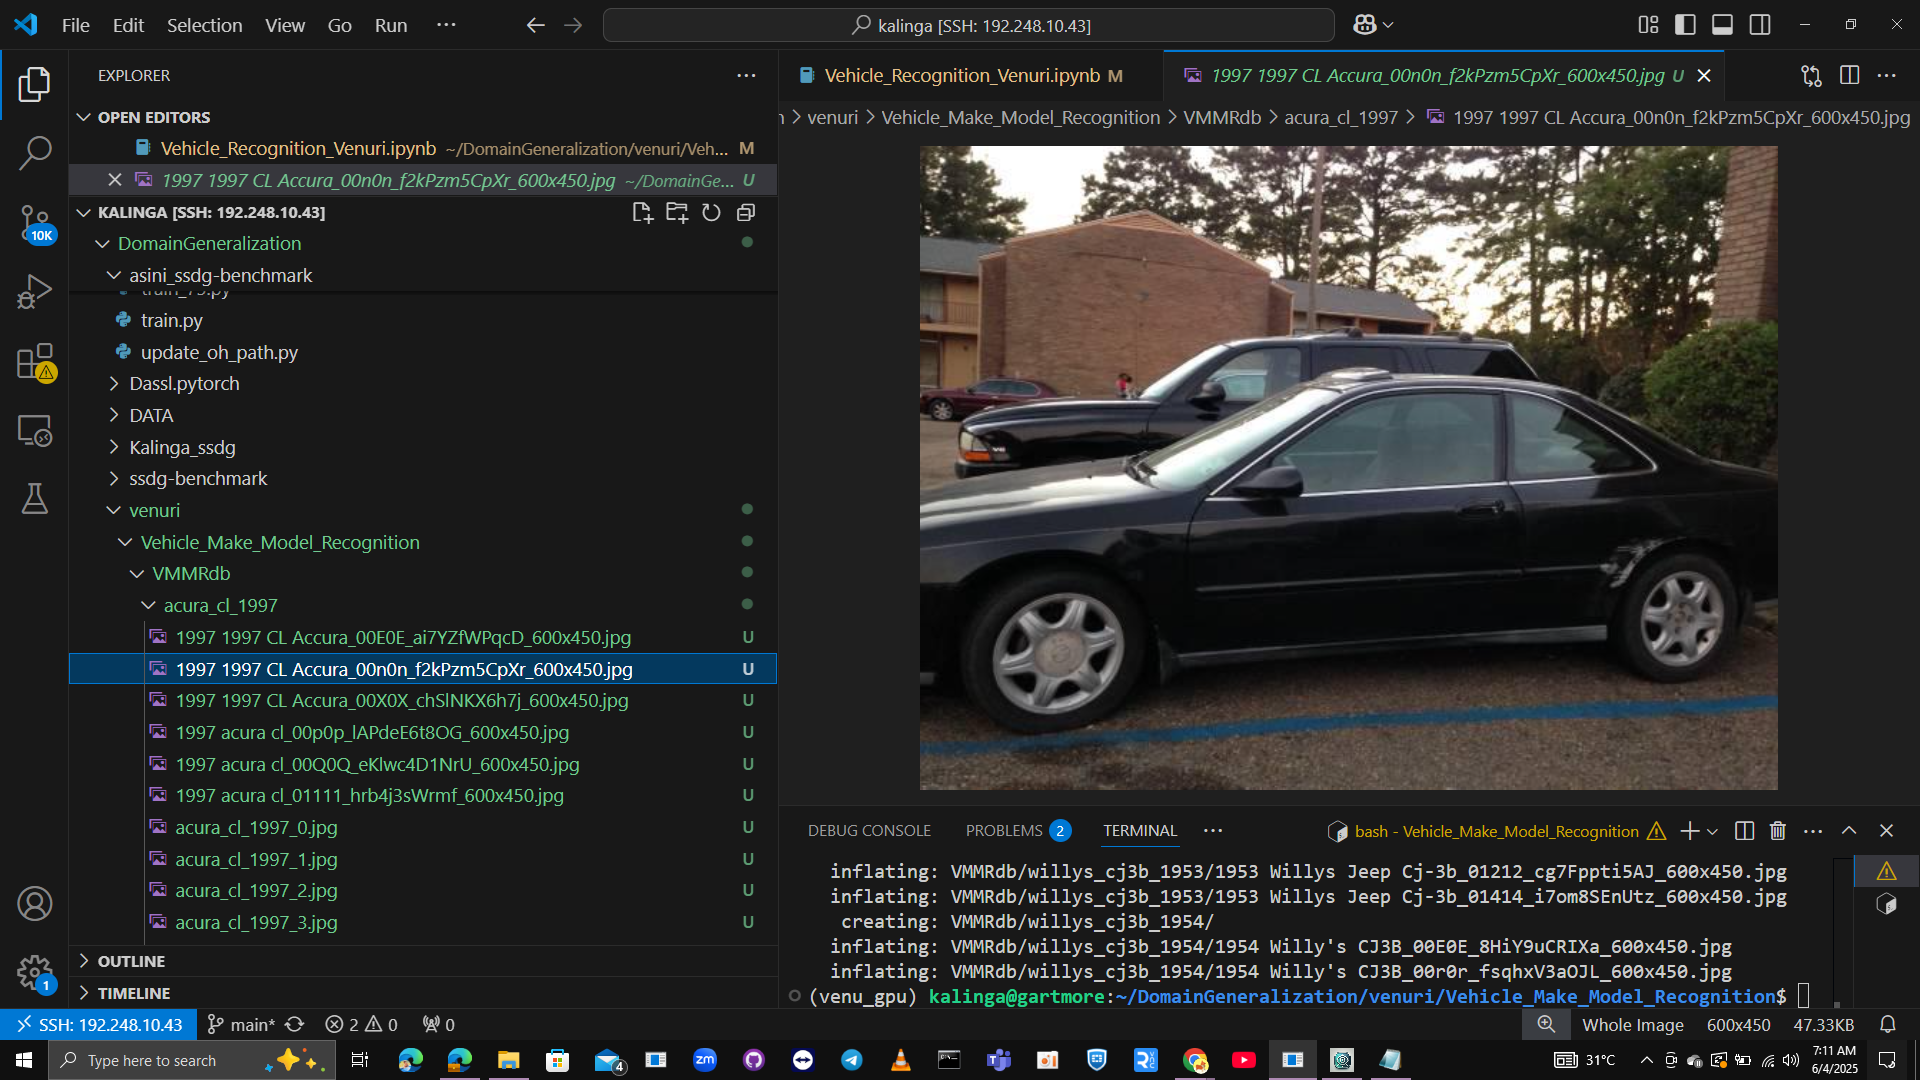

Observe the dataset properties 

In [3]:

from collections import defaultdict
from pathlib import Path

dataset_root = Path('/home/kalinga/DomainGeneralization/venuri/Vehicle_Make_Model_Recognition/VMMRdb')
class_counts = defaultdict(int)

# Loop through class folders
for class_dir in dataset_root.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        valid_images = [img for img in images if img.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}]
        class_counts[class_dir.name] = len(valid_images)

# Dataset summary
print(f"Total classes: {len(class_counts)}")
print(f"Total images: {sum(class_counts.values())}")

# see few samples in class folders 
print("\nSample class counts:")
for cls in list(class_counts.keys())[:10]:
    print(f"{cls}: {class_counts[cls]} images")


Total classes: 9170
Total images: 285086

Sample class counts:
gmc_savana_2004: 9 images
landrover_freelander_2005: 6 images
honda_odyssey_2007: 255 images
chevrolet_cheyenne_1988: 2 images
oldsmobile_cutlass_1995: 30 images
nissan_pathfinder_1998: 77 images
bmw_m3_convertible_2004: 19 images
pontiac_transam_1995: 18 images
dodge_ram_2500_2006: 139 images
nissan_frontier_2011: 2 images


Observe the range of image count in classes to identify the imbalance 

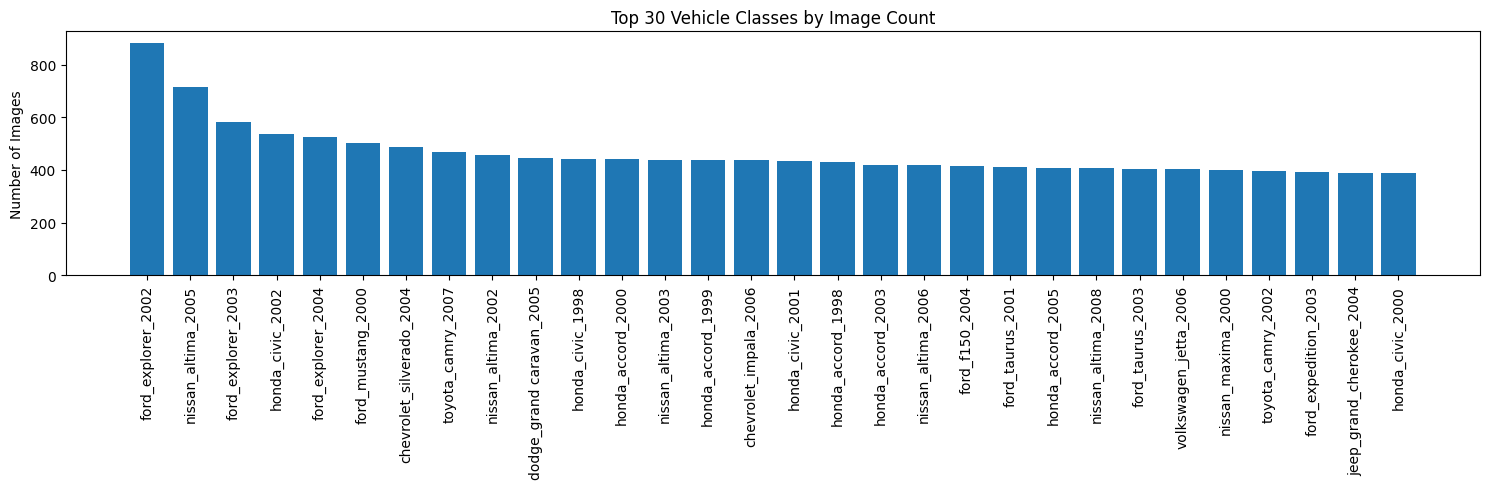

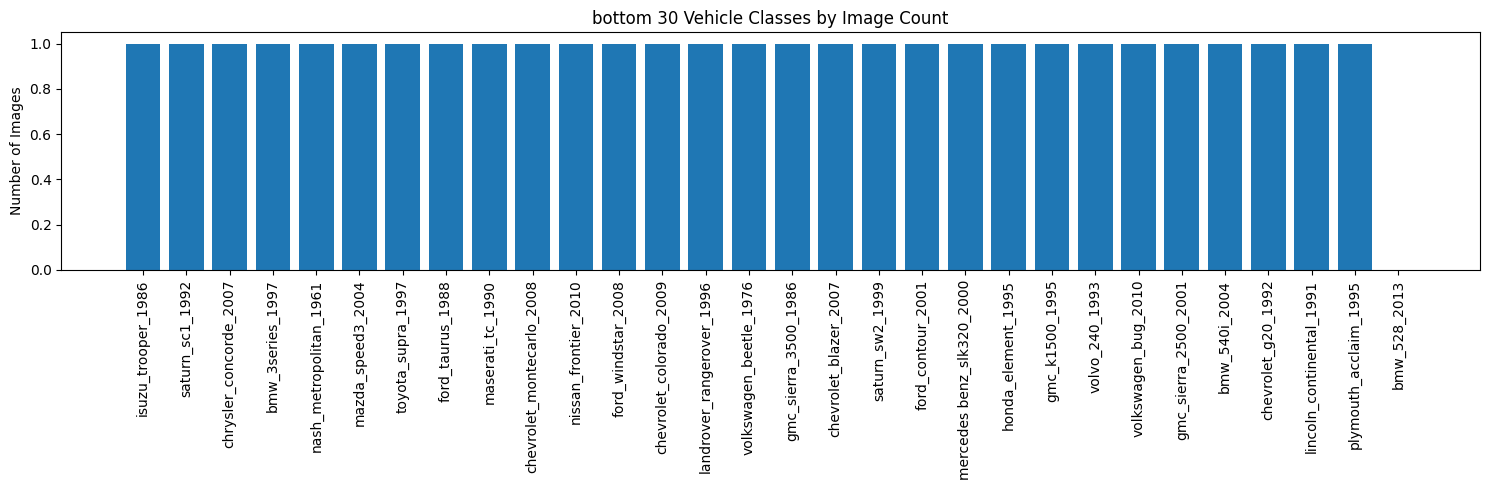

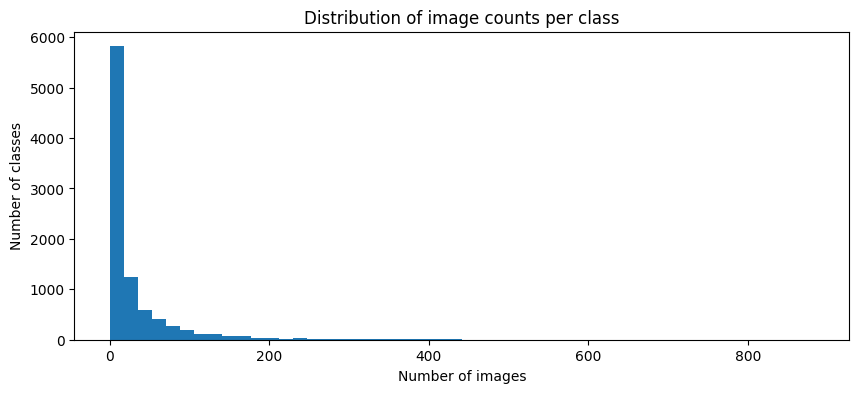

In [4]:
import matplotlib.pyplot as plt

# Sort classes by image count
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
top_classes = sorted_counts[:30]  # Top 30 classes
bottom_classes= sorted_counts[-30:]

# Plot top 
plt.figure(figsize=(15, 5))
plt.bar([cls for cls, _ in top_classes], [cnt for _, cnt in top_classes])
plt.xticks(rotation=90)
plt.title("Top 30 Vehicle Classes by Image Count")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# Plot bottom
plt.figure(figsize=(15, 5))
plt.bar([cls for cls, _ in bottom_classes], [cnt for _, cnt in bottom_classes])
plt.xticks(rotation=90)
plt.title("bottom 30 Vehicle Classes by Image Count")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# Plot histogram of class counts
plt.figure(figsize=(10, 4))
plt.hist(class_counts.values(), bins=50)
plt.title("Distribution of image counts per class")
plt.xlabel("Number of images")
plt.ylabel("Number of classes")
plt.show()


As shown above one class have no images . We can also check for the folders with valid data without plotting the numbers. 

In [5]:

invalid_folders = []

for subdir in dataset_root.iterdir():
    if subdir.is_dir():
        files = list(subdir.glob("*.jpg")) + list(subdir.glob("*.jpeg")) + list(subdir.glob("*.png"))
        if len(files) == 0:
            invalid_folders.append(subdir.name)

print(f"Folders with no valid images: {invalid_folders}")

Folders with no valid images: ['bmw_528_2013']


Only load the dataset with valid data and remove the class with less than 5 data points 

In [4]:
#data set loader to load only the classes with valid data 
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image

class Clean_Dataset(Dataset):
    def __init__(self, root, transform=None, min_images=5):
        self.root = Path(root)
        self.transform = transform
        self.samples = []
        self.classes = []
        self.class_to_idx = {}
        valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}

        for class_dir in sorted(self.root.iterdir()):
            if class_dir.is_dir():
                images = [p for p in class_dir.iterdir() if p.suffix.lower() in valid_exts]
                if len(images) >= min_images:
                    class_name = class_dir.name
                    self.class_to_idx[class_name] = len(self.classes)
                    self.classes.append(class_name)
                    class_idx = self.class_to_idx[class_name]
                    for img_path in images:
                        self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


In [5]:
dataset = Clean_Dataset(dataset_root)

In [6]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import random

labels = np.array([label for _, label in dataset.samples])
unique_classes, class_counts = np.unique(labels, return_counts=True)

# 1) Separate single-sample classes and multi-sample classes
single_sample_classes = unique_classes[class_counts == 1]
multi_sample_classes = unique_classes[class_counts > 1]

# Indices for single-sample classes => all go to train
single_sample_indices = [i for i, lbl in enumerate(labels) if lbl in single_sample_classes]

# Indices and labels for multi-sample classes
multi_sample_indices = [i for i, lbl in enumerate(labels) if lbl in multi_sample_classes]
multi_sample_labels = labels[multi_sample_indices]

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# 2) Stratified split multi-sample classes into train and temp(val+test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio + test_ratio, random_state=42)
train_multi_idx, temp_idx = next(sss1.split(np.zeros(len(multi_sample_labels)), multi_sample_labels))

# Map back indices to original dataset
train_multi_indices = np.array(multi_sample_indices)[train_multi_idx]
temp_indices = np.array(multi_sample_indices)[temp_idx]
temp_labels = labels[temp_indices]

# 3) Split temp into val and test stratified as much as possible
# But handle classes with only 1 sample in temp by random assignment
val_indices = []
test_indices = []

# Find classes in temp and their indices
temp_classes, temp_class_counts = np.unique(temp_labels, return_counts=True)

for cls in temp_classes:
    cls_indices = temp_indices[temp_labels == cls]
    if len(cls_indices) == 1:
        # Randomly assign this single sample to val or test
        if random.random() < 0.5:
            val_indices.append(cls_indices[0])
        else:
            test_indices.append(cls_indices[0])
    else:
        # For classes with multiple samples, do stratified split
        cls_labels = labels[cls_indices]
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)
        val_cls_idx, test_cls_idx = next(sss2.split(np.zeros(len(cls_labels)), cls_labels))
        val_indices.extend(cls_indices[val_cls_idx])
        test_indices.extend(cls_indices[test_cls_idx])

# Combine train indices
train_indices = np.concatenate([single_sample_indices, train_multi_indices])

# Create dataset subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 194982
Val size: 40463
Test size: 43101


In [ ]:
#save the splits to folders 
import shutil
def get_original_samples(subset):
    return [subset.dataset.samples[i] for i in subset.indices]

# Save images to folders
def save_to_folder(samples, root_dir):
    for img_path, label in samples:
        class_name = dataset.classes[label]
        class_dir = os.path.join(root_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        dest_path = os.path.join(class_dir, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)

# Create splits 
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)
os.makedirs("data/test", exist_ok=True)

# Save datasets
save_to_folder(get_original_samples(train_dataset), "data/train")
save_to_folder(get_original_samples(val_dataset), "data/val_new")
save_to_folder(get_original_samples(test_dataset), "data/test_new")

print("Images successfully saved to data/train, data/val, data/test.")

Images successfully saved to data/train, data/val, data/test.


2. Model Selection and training  

Here I considered Swin transformer, RCCN, Faster-RCCN , BCCN ,Yolo and EfficientNet.

From above models after considering the balance between the accuracy and the deployement cost , I choose efficient net eventhough the higher accuracies can be acheived through swin transformers.

The factors considered are, 

the accuracy 
memory usage 
latency 
inference time 
complexity 

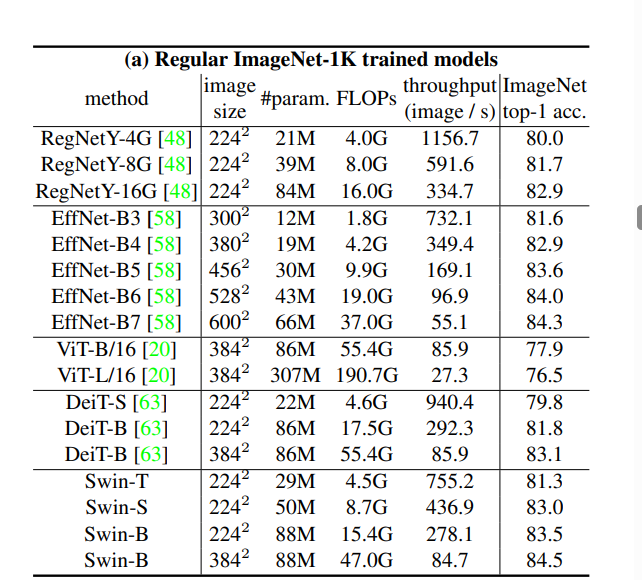

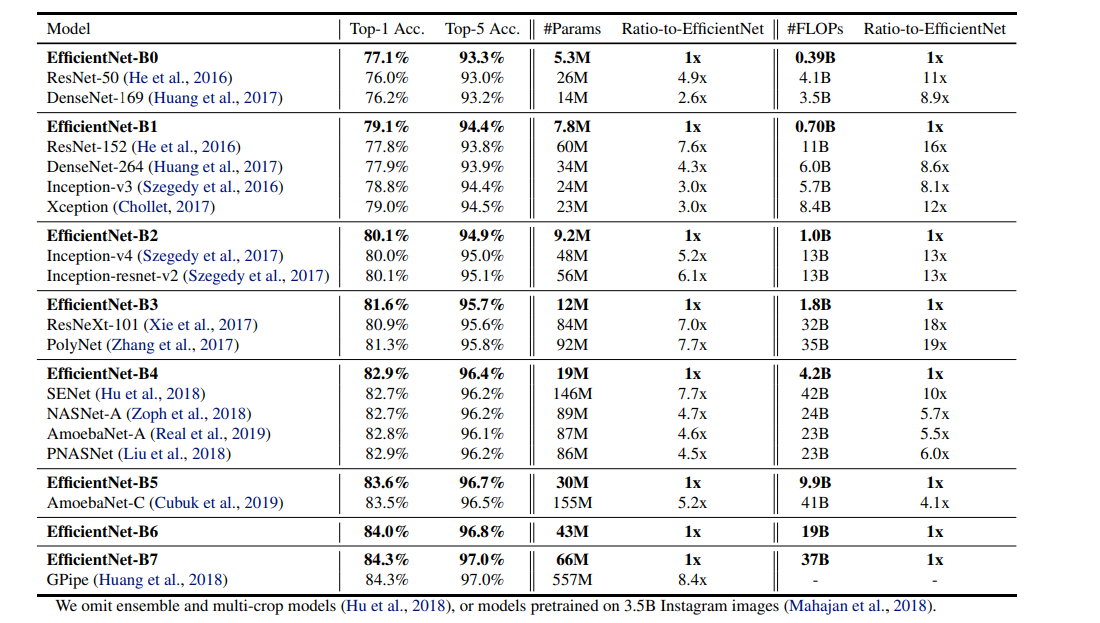

Load data from train, val, test folders. Here for the training data i have additionalyadded augmentations to improve the performnace.


In [4]:
torch.cuda.empty_cache()
# preprocess data
efficientnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])

#for training data add augmentations 

img_augmentation = transforms.Compose([
    transforms.RandomRotation(degrees=60),                     # Rotation
    transforms.RandomResizedCrop(224, scale=(0.7, 1.2)),       # Zoom (in/out)
    transforms.ColorJitter(brightness=0.4, contrast=0.3),      # Brightness and contrast
    transforms.RandomHorizontalFlip(),                         # Horizontal flip                           
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],           # EfficientNet normalization
                         std=[0.229, 0.224, 0.225]),
])
# Paths
train_path = "/home/kalinga/DomainGeneralization/venuri/Vehicle_Make_Model_Recognition/data/train"
val_path = "/home/kalinga/DomainGeneralization/venuri/Vehicle_Make_Model_Recognition/data/val_new"
test_path = "/home/kalinga/DomainGeneralization/venuri/Vehicle_Make_Model_Recognition/data/test_new"

# Datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=img_augmentation)
val_dataset = datasets.ImageFolder(root=val_path, transform=efficientnet_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=efficientnet_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=80, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=80, shuffle=False, num_workers=4)

# Save class names to a text file
with open("class_names.txt", "w") as f:
    for class_name in train_dataset.classes:
        f.write(f"{class_name}\n")


In [5]:
import timm
import torch.nn as nn
import torch.optim as optim

# Load pretrained model without the final layer and add a layer as the classifier 
base_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='avg')


class EfficientNet_Vehicle(nn.Module):
    def __init__(self, base_model, num_classes, dropout_rate=0.2):
        super(EfficientNet_Vehicle, self).__init__()
        self.base = base_model  # efficientnet_b4 backbone
        self.bn = nn.BatchNorm1d(base_model.num_features)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(base_model.num_features, num_classes)

    def forward(self, x):
        x = self.base(x)             
        x = self.bn(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Our model
num_classes = len(train_dataset.classes)  
model = EfficientNet_Vehicle(base_model, num_classes=num_classes)

# Move model to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(train_dataset.targets), y=train_dataset.targets)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0003)
# Separate parameters
classifier_params = list(model.fc.parameters()) + list(model.bn.parameters()) + list(model.dropout.parameters())
backbone_params = list(model.base.parameters())

# Create optimizer with different learning rates
optimizer = optim.Adam([
    {'params': backbone_params, 'lr': 0.0003},         # Lower LR for pretrained EfficientNet
    {'params': classifier_params, 'lr': 0.001}         # Higher LR for new classifier
])



In [14]:
# Training 
import time
epochs = 10
# Create a directory to save checkpoints
os.makedirs("checkpoints_jupyter", exist_ok=True)

best_val_acc = 0.0  # Track the best validation accuracy
start = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)

            idx_to_class_val = val_dataset.classes
            idx_to_class_train = train_dataset.classes


            labels_names = [idx_to_class_val[idx] for idx in labels]
            predicted_names = [idx_to_class_train[idx] for idx in predicted]
            val_correct += sum(p == t for p, t in zip(predicted_names, labels_names))

    val_loss /= len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save checkpoint
    
    # Savethe best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = "checkpoints_jupyter/best_model.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated and saved at epoch {epoch+1}")

print("Total time for training: ", time.time() - start)


Epoch 1/10: Train Loss: 0.3986, Train Acc: 73.26%, Val Loss: 19.8770, Val Acc: 37.97%
Best model updated and saved at epoch 1
Epoch 2/10: Train Loss: 0.3898, Train Acc: 73.49%, Val Loss: 19.6228, Val Acc: 37.83%
Epoch 3/10: Train Loss: 0.3595, Train Acc: 74.90%, Val Loss: 20.2152, Val Acc: 38.28%
Best model updated and saved at epoch 3
Epoch 4/10: Train Loss: 0.3355, Train Acc: 76.03%, Val Loss: 20.6569, Val Acc: 38.87%
Best model updated and saved at epoch 4
Epoch 5/10: Train Loss: 0.3210, Train Acc: 76.84%, Val Loss: 20.7282, Val Acc: 38.46%
Epoch 6/10: Train Loss: 0.2971, Train Acc: 77.86%, Val Loss: 20.7682, Val Acc: 39.24%
Best model updated and saved at epoch 6
Epoch 7/10: Train Loss: 0.2840, Train Acc: 78.72%, Val Loss: 20.8924, Val Acc: 39.88%
Best model updated and saved at epoch 7
Epoch 8/10: Train Loss: 0.2617, Train Acc: 79.83%, Val Loss: 21.0346, Val Acc: 39.58%
Epoch 9/10: Train Loss: 0.2490, Train Acc: 80.65%, Val Loss: 21.1867, Val Acc: 40.59%
Best model updated and sav

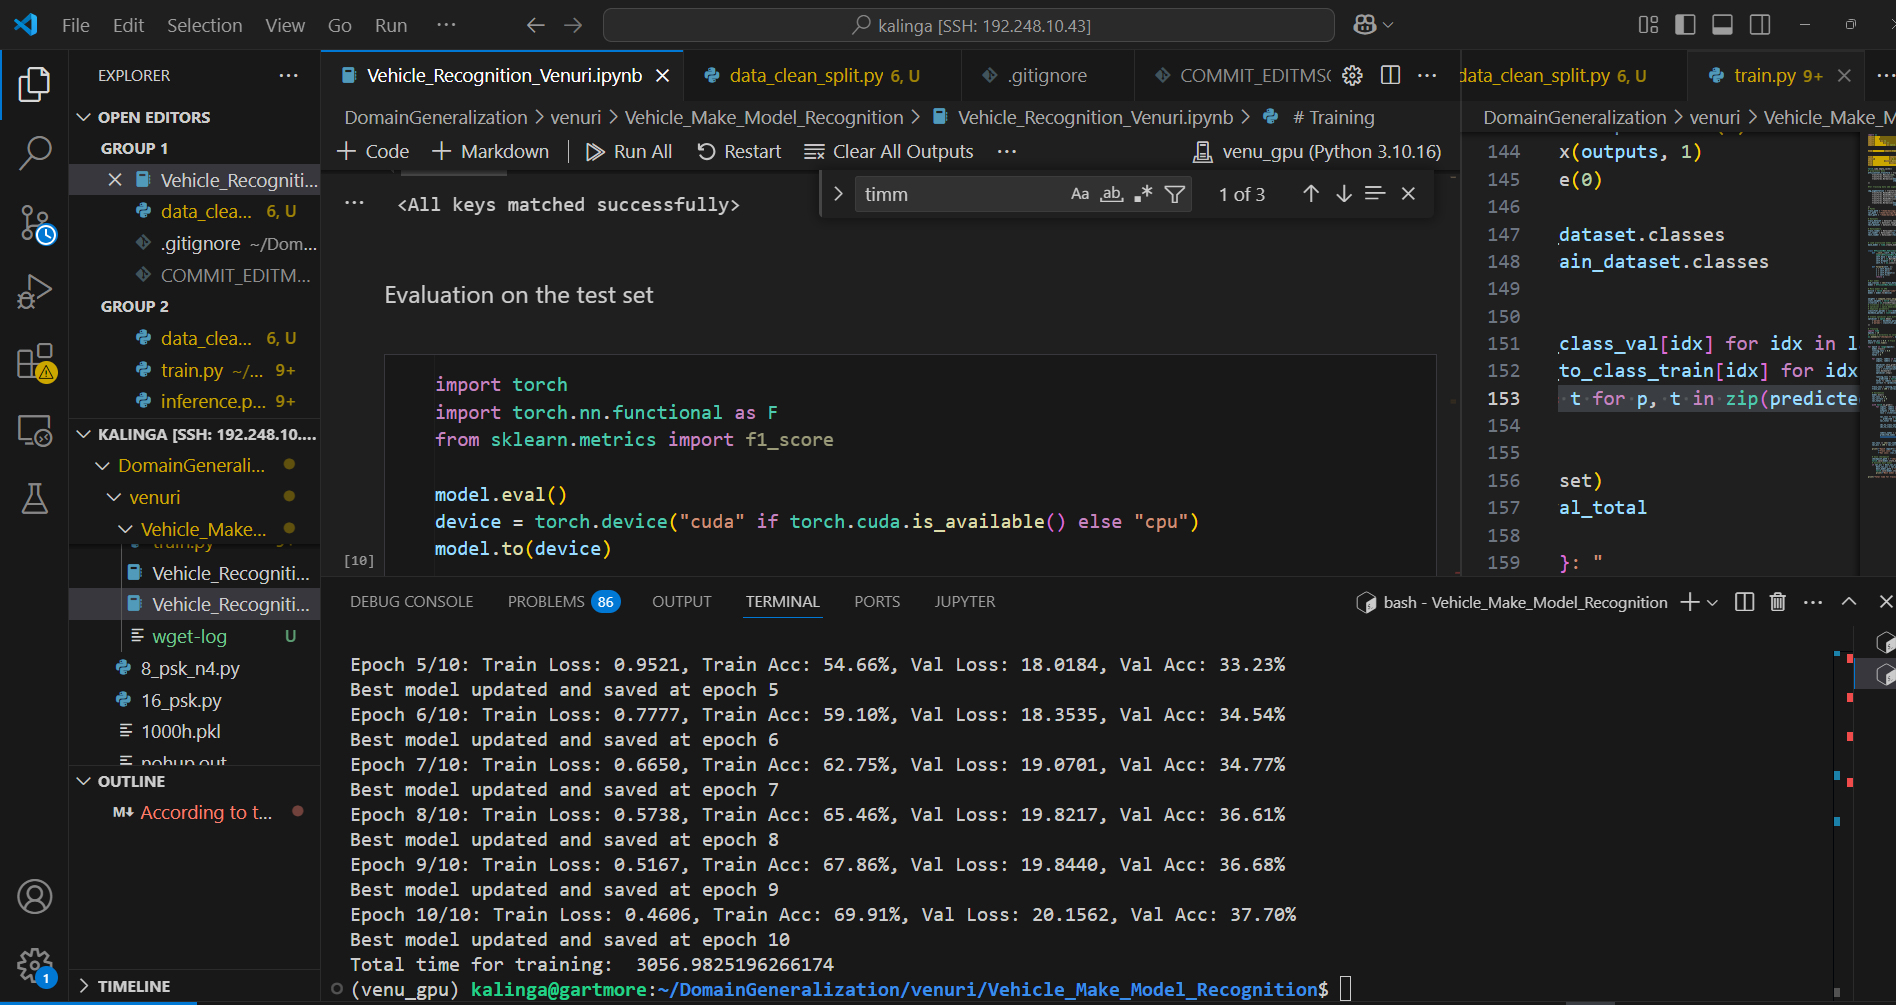
training by python file 

In [6]:
model.load_state_dict(torch.load("/home/kalinga/DomainGeneralization/venuri/Vehicle_Make_Model_Recognition/checkpoints_jupyter/best_model.pth"))

/tmp/ipykernel_3007323/4051712128.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/kalinga/DomainGeneralization/venuri/Vehicle_Mak

<All keys matched successfully>

Evaluation on the test set 

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)  
        probs = F.softmax(outputs, dim=1)
        
        all_preds.append(probs.cpu())
        all_labels.append(labels.cpu())
        


all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Convert to numpy for sklearn
y_true = all_labels.numpy()
y_pred_top1 = all_preds.argmax(dim=1).numpy()


# Assuming test_dataset.classes is a list: index -> class name
idx_to_class_test = test_dataset.classes
idx_to_class_train = train_dataset.classes

# Convert all true and predicted indices to class names
y_true_names = [idx_to_class_test[idx] for idx in y_true]
y_pred_names = [idx_to_class_train[idx] for idx in y_pred_top1]

# Calculate accuracy by comparing names
correct = sum(p == t for p, t in zip(y_pred_names, y_true_names))
accuracy = correct / len(y_true_names) * 100
print(f"Top-1 Accuracy (by class names): {accuracy:.2f}%")

# For top-5 accuracy
top5_preds = all_preds.topk(5, dim=1).indices.numpy()
top5_preds_names = [[idx_to_class_train[idx] for idx in top5] for top5 in top5_preds]

top5_correct = 0
for true_name, pred_names in zip(y_true_names, top5_preds_names):
    if true_name in pred_names:
        top5_correct += 1
top5_acc = top5_correct / len(y_true_names) * 100
print(f"Top-5 Accuracy (by class names): {top5_acc:.2f}%")



NameError: name 'model' is not defined

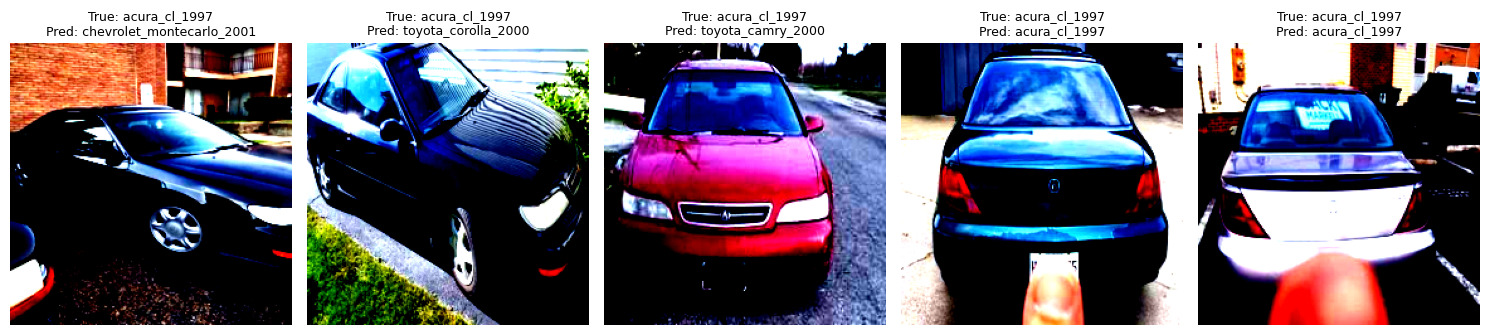

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.figure(figsize=(15, 5))

for i in range(5):
    img, label = test_dataset[i]  # dataset: your validation/test Dataset
    img_tensor = img.cpu() if torch.is_tensor(img) else img
    img_np = img_tensor.numpy().transpose(1, 2, 0)  # CHW to HWC

    # Optional: clip to valid range if needed
    img_np = np.clip(img_np, 0, 1)

    idx_to_class_test = test_dataset.classes
    idx_to_class_train = train_dataset.classes
    model.eval()  # Important: set to eval mode

    # Predict (optional model prediction step)
    with torch.no_grad():
        
        output = model(img.unsqueeze(0).to(device))
        pred_idx = output.argmax(dim=1).item()
        pred_name = idx_to_class_train[pred_idx]
        true_name = idx_to_class_test[label]

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_np)
    plt.title(f"True: {true_name}\nPred: {pred_name}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.savefig("lightweight_visualization.png", dpi=300)
plt.show()


In [11]:
from sklearn.metrics import f1_score

f1_macro = f1_score(y_true_names, y_pred_names, average='macro')
f1_weighted = f1_score(y_true_names, y_pred_names, average='weighted')
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

F1 Score (Macro): 0.3733
F1 Score (Weighted): 0.3639


Observe the confusion matrix 

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
# Suppose class_names = train_dataset.classes
class_names = train_dataset.classes
# Encode class names if needed
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(class_names)

# Convert string labels to integer indices
y_true_int = le.transform(y_true_names)
y_pred_int = le.transform(y_pred_names)

# Compute confusion matrix
cm = confusion_matrix(y_true_int, y_pred_int)

# Plot the matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

# Show labels (optionally limit for clarity)
tick_marks = np.arange(len(le.classes_))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(le.classes_, rotation=45, ha='right', fontsize=6)
ax.set_yticklabels(le.classes_, fontsize=6)

ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix')


threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0:  # Only annotate non-zero cells
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > threshold else "black",
                    fontsize=4)

plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.close()
print("Confusion matrix saved as 'confusion_matrix.png'")


Confusion matrix saved as 'confusion_matrix.png'


### According to the confusion matrix many confusions are occcur due to the visual similarity. Here the class imbalance have addressed usign the weighted loss which depend on the number of data in each class. 

In [16]:
import time
import torch

# Set model to evaluation mode
model.eval()
device_type = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device_type)

# Create test loader with batch size 30
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False, num_workers=4)

# Warm-up (especially useful for GPU)
for _ in range(3):
    for inputs, _ in test_loader:
        inputs = inputs.to(device_type)
        with torch.no_grad():
            _ = model(inputs)
        break  # Only one batch for warm-up

# Run timed inference on real data
total_time = 0
num_images = 0

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device_type)
        batch_size = inputs.size(0)

        start = time.time()
        _ = model(inputs)
        end = time.time()

        total_time += (end - start)
        num_images += batch_size
        break  # only one batch as per your request

fps = num_images / total_time
print(f"Device: {device_type.upper()}")
print(f"Batch Size: {batch_size}, FPS: {fps:.2f}, Time per image: {1000 / fps:.2f} ms")

if device_type == "cuda":
    print(f"Max GPU Memory Usage: {torch.cuda.max_memory_allocated() / 1e6:.2f} MB")
    torch.cuda.reset_max_memory_allocated()


Device: CUDA
Batch Size: 30, FPS: 2675.17, Time per image: 0.37 ms
Max GPU Memory Usage: 1072.92 MB


/home/kalinga/miniconda3/envs/venu_gpu/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [18]:
!pip install onnx


In [21]:
import torch
import torch.onnx
# Set the model to eval mode and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Dummy input for export ([1, 3, 224, 224]) on the same device
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=11
)
print("ONNX model exported to model.onnx")


ONNX model exported to model.onnx


In [23]:
import os
from torchvision.utils import save_image
import torchvision.transforms as T

# Directory to save calibration images
calib_dir = "calib_images"
os.makedirs(calib_dir, exist_ok=True)

# Optional: Undo normalization to get valid images
# Replace mean/std with your dataset normalization stats if any
unnormalize = T.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

count = 0
for inputs, _ in val_loader:
    for i in range(inputs.size(0)):
        if count >= 100:
            break
        img = unnormalize(inputs[i]).clamp(0, 1)  # Undo norm and clamp to valid range
        save_image(img, os.path.join(calib_dir, f"img_{count}.png"))
        count += 1
    if count >= 100:
        break

print(f"Saved {count} calibration images to {calib_dir}")


Saved 100 calibration images to calib_images


In [19]:
import os

os.system("trtexec --onnx=model.onnx --int8 --calib=calib_images/ --calibBatch=8 --saveEngine=model_int8.engine")


sh: 1: trtexec: not found


32512